In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras 
from scipy.stats import entropy
import sys
sys.path.append('..')
sys.path.append('../odcd/cd/')
from odcd.metrics import DataTracker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
import matplotlib.pyplot as plt
%matplotlib inline

/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fdz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: 

In [2]:
import model_symmetries as vsf

# Data prep

6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64

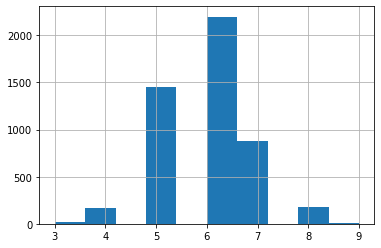

In [3]:
df_white = pd.read_csv('/home/fdz/git/concept_drift_exps/data/wine/winequality_white.csv')
df_white['quality'].hist(bins=10)
df_white['quality'].value_counts() / len(df_white)

In [4]:
binary_target = True
if binary_target:
    df_white['target'] = df_white['quality'].apply(lambda x: 0 if x < 6 else 1)
else:
    df_white['target'] = df_white['quality']
df_white.drop('quality', axis=1, inplace=True)
target = 'target'
df_white[target].value_counts() / len(df_white)

1    0.665169
0    0.334831
Name: target, dtype: float64

In [5]:
features = [col for col in df_white.columns if col != target]
X, y = df_white[features].values, df_white[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
scale = True
if scale:
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

In [7]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
y_train = np.delete(y_train, np.where(~y_train.any(axis=0)), axis=1)
y_test = np.delete(y_test, np.where(~y_test.any(axis=0)), axis=1)

# NN model

In [9]:
def model():
    
    x_in = tf.keras.layers.Input(shape=(11, ))
    x = tf.keras.layers.Dense(100, activation='relu')(x_in)
    #x = tf.keras.layers.Dense(50, activation='relu')(x_in)
    if binary_target:
        out = tf.keras.layers.Dense(2, activation='softmax')(x)
    else:
        out = tf.keras.layers.Dense(7, activation='softmax')(x)
    clf = tf.keras.models.Model(x_in, out)
    clf.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    clf.summary()
    return clf

In [10]:
clf = model()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________


In [11]:
clf.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 3673 samples, validate on 1225 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3673/3673 [==============================] - 0s 58us/sample - loss: 0.6064 - acc: 0.6646 - val_loss: 0.5737 - val_acc: 0.6824
Epoch 2/100
3673/3673 [==============================] - 0s 25us/sample - loss: 0.5471 - acc: 0.7000 - val_loss: 0.5380 - val_acc: 0.7110
Epoch 3/100
3673/3673 [==============================] - 0s 24us/sample - loss: 0.5242 - acc: 0.7332 - val_loss: 0.5234 - val_acc: 0.7273
Epoch 4/100
3673/3673 [==============================] - 0s 26us/sample - loss: 0.5145 - acc: 0.7433 - val_loss: 0.5137 - val_acc: 0.7445
Epoch 5/100
3673/3673 [==============================] - 0s 27us/sample - loss: 0.5091 - acc: 0.7482 - val_loss: 0.5187 - val_acc: 0.7306
Epoch 6/100
3673/3673 [==============================] - 0s 28us/sample - loss: 0.5081 - acc: 0.7473 - val_loss: 0.5095 - val_acc: 0.7461
Epoch 7/100
3673/3673 [==============================] - 0s 27us/sample - lo

Epoch 58/100
3673/3673 [==============================] - 0s 26us/sample - loss: 0.4607 - acc: 0.7803 - val_loss: 0.4864 - val_acc: 0.7682
Epoch 59/100
3673/3673 [==============================] - 0s 26us/sample - loss: 0.4602 - acc: 0.7816 - val_loss: 0.4913 - val_acc: 0.7624
Epoch 60/100
3673/3673 [==============================] - 0s 26us/sample - loss: 0.4600 - acc: 0.7808 - val_loss: 0.4896 - val_acc: 0.7682
Epoch 61/100
3673/3673 [==============================] - 0s 25us/sample - loss: 0.4594 - acc: 0.7819 - val_loss: 0.4895 - val_acc: 0.7600
Epoch 62/100
3673/3673 [==============================] - 0s 24us/sample - loss: 0.4615 - acc: 0.7822 - val_loss: 0.4916 - val_acc: 0.7649
Epoch 63/100
3673/3673 [==============================] - 0s 24us/sample - loss: 0.4584 - acc: 0.7797 - val_loss: 0.4950 - val_acc: 0.7543
Epoch 64/100
3673/3673 [==============================] - 0s 25us/sample - loss: 0.4581 - acc: 0.7789 - val_loss: 0.4868 - val_acc: 0.7682
Epoch 65/100
3673/3673 [===

In [12]:
y_preds_train = clf.predict(X_train)
y_preds_test = clf.predict(X_test)

In [13]:
y_train, y_test = np.argmax(y_train, axis=1), np.argmax(y_test, axis=1)
y_preds_train, y_preds_test = np.argmax(y_preds_train, axis=1), np.argmax(y_preds_test, axis=1)

In [14]:
print('Accuracy train:', accuracy_score(y_preds_train, y_train))
print('Accuracy testL', accuracy_score(y_preds_test, y_test))

Accuracy train: 0.7922679008984481
Accuracy testL 0.773061224489796


In [15]:
print('Confusion matrix train')
confusion_matrix(y_preds_train, y_train)

Confusion matrix train


array([[ 771,  313],
       [ 450, 2139]])

In [16]:
print('Confusion matrix test')
confusion_matrix(y_preds_test, y_test)

Confusion matrix test


array([[261, 120],
       [158, 686]])

# Streaming cd

### Prepare red wines

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

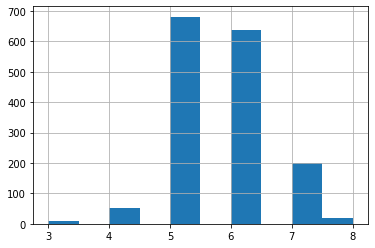

In [17]:
df_red = pd.read_csv('/home/fdz/git/concept_drift_exps/data/wine/winequality_red.csv')
df_red['quality'].hist(bins=10)
df_red['quality'].value_counts() / len(df_red)

In [18]:
if binary_target:
    df_red['target'] = df_red['quality'].apply(lambda x: 0 if x < 6 else 1)
else:
    df_red['target'] = df_red['quality']
df_red.drop('quality', axis=1, inplace=True)
target = 'target'
df_red[target].value_counts() / len(df_red)

1    0.534709
0    0.465291
Name: target, dtype: float64

In [19]:
features = [col for col in df_red.columns if col != target]
X_red, y_red = df_red[features].values, df_red[target].values
if scale:
    X_red = scaler.transform(X_red)

In [20]:
y_preds_red  = clf.predict(X_red)
y_preds_red = np.argmax(y_preds_red, axis=1)

In [21]:
print('Accuracy red:', accuracy_score(y_preds_red, y_red))

Accuracy red: 0.5209505941213258


In [22]:
print('Confusion matrix reds')
confusion_matrix(y_preds_red, y_red)

Confusion matrix reds


array([[719, 741],
       [ 25, 114]])

### Train symmetry finder

In [23]:
vae = vsf.VaeSymmetryFinder(clf, input_shape=(11,), output_shape=(2, ), intermediate_dim=256, latent_dim=8)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 11)           0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 11)           0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          3072        reshape[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 8)            2056        dense_2[0][0]                    
__________________________________________________________________________________________________
z_log_

In [24]:
vae.fit(X_train, x_test=X_test, epochs=200)

Train on 3673 samples, validate on 1225 samples
Epoch 1/200
3673/3673 [==============================] - 0s 93us/sample - loss: 0.2655 - val_loss: 0.1975
Epoch 2/200
3673/3673 [==============================] - 0s 15us/sample - loss: 0.1861 - val_loss: 0.1804
Epoch 3/200
3673/3673 [==============================] - 0s 14us/sample - loss: 0.1743 - val_loss: 0.1678
Epoch 4/200
3673/3673 [==============================] - 0s 14us/sample - loss: 0.1581 - val_loss: 0.1408
Epoch 5/200
3673/3673 [==============================] - 0s 16us/sample - loss: 0.1157 - val_loss: 0.0948
Epoch 6/200
3673/3673 [==============================] - 0s 16us/sample - loss: 0.0779 - val_loss: 0.0671
Epoch 7/200
3673/3673 [==============================] - 0s 17us/sample - loss: 0.0578 - val_loss: 0.0612
Epoch 8/200
3673/3673 [==============================] - 0s 16us/sample - loss: 0.0488 - val_loss: 0.0486
Epoch 9/200
3673/3673 [==============================] - 0s 15us/sample - loss: 0.0435 - val_loss: 0.045

3673/3673 [==============================] - 0s 17us/sample - loss: 2.9971e-04 - val_loss: 4.5745e-04
Epoch 148/200
3673/3673 [==============================] - 0s 20us/sample - loss: 3.2661e-04 - val_loss: 4.6326e-04
Epoch 149/200
3673/3673 [==============================] - 0s 17us/sample - loss: 4.4412e-04 - val_loss: 4.0935e-04
Epoch 150/200
3673/3673 [==============================] - 0s 16us/sample - loss: 3.5713e-04 - val_loss: 3.7983e-04
Epoch 151/200
3673/3673 [==============================] - 0s 16us/sample - loss: 2.7300e-04 - val_loss: 4.9012e-04
Epoch 152/200
3673/3673 [==============================] - 0s 17us/sample - loss: 3.1515e-04 - val_loss: 9.7203e-04
Epoch 153/200
3673/3673 [==============================] - 0s 17us/sample - loss: 3.2260e-04 - val_loss: 3.6339e-04
Epoch 154/200
3673/3673 [==============================] - 0s 18us/sample - loss: 2.4829e-04 - val_loss: 3.5796e-04
Epoch 155/200
3673/3673 [==============================] - 0s 17us/sample - loss: 2.83

### stream

In [25]:
def sample_window(X_test, y_test, window):
    samples_rnd = np.random.choice(range(len(X_test)), window, replace=False)
    X_test_samples = X_test[samples_rnd, :]
    y_test_samples = y_test[samples_rnd]
    return X_test_samples, y_test_samples

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
def sliding_window(X_orig, X_cd, window_size, cd_start, nb_samples_tot, start):
    
    cd_full = 2 * cd_start
    
    acc = []
    mu = []
    var = []
    ps = []
    entrs = []
    
    ps_tmp = []
    xs = []
    ys = []
    for i in range(nb_samples_tot):
        if i < cd_start:
            p = 0
        else:
            p = (i - cd_start)/cd_start
        if p > 1:
            p = 1
        
        pp = np.random.choice([0, 1], p=[p, 1-p])
        if pp == 1:
            idx = np.random.choice(range(len(X_orig)))
            x = X_test[idx]
            y = y_test[idx]
        else: 
            idx = np.random.choice(range(len(X_cd)))
            x = X_red[idx]
            y = y_red[idx]
        
        if i % window_size == 0 and i != 0:
            xs = np.asarray(xs)
            ys = np.asarray(ys)
            ps_tmp = np.asarray(ps_tmp)
            
            vae_outs_test = vae.vae.predict(xs)
            symm_samples_test = vae_outs_test[0]
            orig_preds_test = vae_outs_test[1]
            trans_preds_test = vae_outs_test[2]
    
            kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
            pred = np.argmax(orig_preds_test, axis=1)
            pred_prob = orig_preds_test[:, pred[0]]
            r = accuracy_score(pred, ys)
        
            mu.append(kl_test.mean())
            var.append(kl_test.var())
            acc.append(r)
            ps.append(ps_tmp.mean())
            print(mu)
            xs = []
            ps_tmp = []
            ys = []
        else:
            xs.append(x)
            ys.append(y)
            ps_tmp.append(p)
        
        if i == cd_start:
            window_start = len(mu)
        if i == cd_full:
            window_full = len(mu)
            
    cd_start = cd_start - start
    cd_full = cd_full - start
    df = pd.DataFrame()
    df['accuracy'] = acc[start:]
    df['contamination'] = ps[start:]
    df['entropy_mean'] = mu[start:]
    df['entropy_var'] = var[start:]
    
    return df, window_start, window_full

In [281]:
def rolling_stats(X_orig, X_cd, cd_start, nb_samples_tot, start):
    cd_full = 2 * cd_start
    m = Mean()
    a = Mean()
    v = Var()

    rws = []
    entrs = []
    probs = []

    acc = []
    mu = []
    var = []
    ps = []
    
    for i in range(nb_samples_tot):
        if i < cd_start:
            p = 0
        else:
            p = (i - cd_start)/cd_start
        if p > 1:
            p = 1
        
        pp = np.random.choice([0, 1], p=[p, 1-p])
        if pp == 1:
            idx = np.random.choice(range(len(X_orig)))
            x = X_test[idx].reshape(1, -1)
            y = y_test[idx]
        else: 
            idx = np.random.choice(range(len(X_cd)))
            x = X_red[idx].reshape(1, -1)
            y = y_red[idx]
            
        vae_outs_test = vae.vae.predict(x)
        symm_samples_test = vae_outs_test[0]
        orig_preds_test = vae_outs_test[1]
        trans_preds_test = vae_outs_test[2]
    
        kl_test = entropy(orig_preds_test.T, trans_preds_test.T)[0]
        pred = np.argmax(orig_preds_test, axis=1)
        pred_prob = orig_preds_test[:, pred[0]]
        r = is_good(pred, y)
        
        a.update(r)
        m.update(kl_test)
        v.update(kl_test)
        mm, vv, aa = m.get(), v.get(), a.get()

        mu.append(mm)
        var.append(vv)
        acc.append(aa)
        ps.append(p)

        rws.append(r)
        entrs.append(kl_test)
        probs.append(pred_prob)
    
    cd_start = cd_start - start
    cd_full = cd_full - start
    df = pd.DataFrame()
    df['rw'] = rws[start:]
    #df['rw'] = df['rw'].apply(lambda x:'r' if x == 0 else 'b')
    df['entropy'] = entrs[start:]
    df['pred_prob'] = probs[start:]
    df['accuracy'] = acc[start:]
    df['contamination'] = ps[start:]
    df['entropy_mean'] = mu[start:]
    df['entropy_var'] = var[start:]
    
    return df

In [266]:
def is_good(y_pred, y_true):
    if y_pred == y_true:
        return 1
    else:
        return 0

In [28]:
X_all = np.concatenate((X_test, X_red), axis=0)
y_all = np.concatenate((y_test, y_red), axis=0)

In [29]:
vae_outs_test = vae.vae.predict(X_test)
symm_samples_test = vae_outs_test[0]
orig_preds_test = vae_outs_test[1]
trans_preds_test = vae_outs_test[2]
    
kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
baseline_std_plus = kl_test.mean() + kl_test.std()
baseline_std_minus = kl_test.mean() - kl_test.std()

In [30]:
kl_test.std()

0.0007870171

In [31]:
kl_test.mean()

0.00023101622

### Rolling means and var

In [32]:
cd_start = 5000
cd_full = 2 * cd_start
nb_samples_tot = 15000
start = 100

In [34]:
df = vsf.rolling_stats(vae, X_test, y_test, X_red, y_red, cd_start, nb_samples_tot, start)

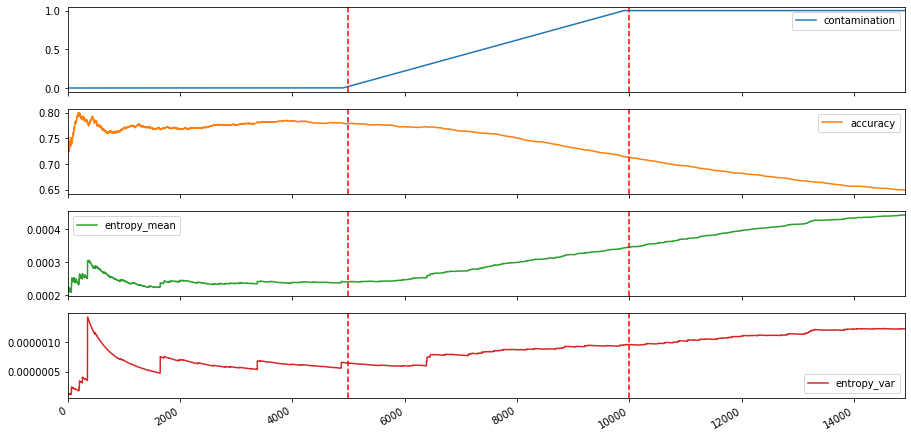

In [35]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

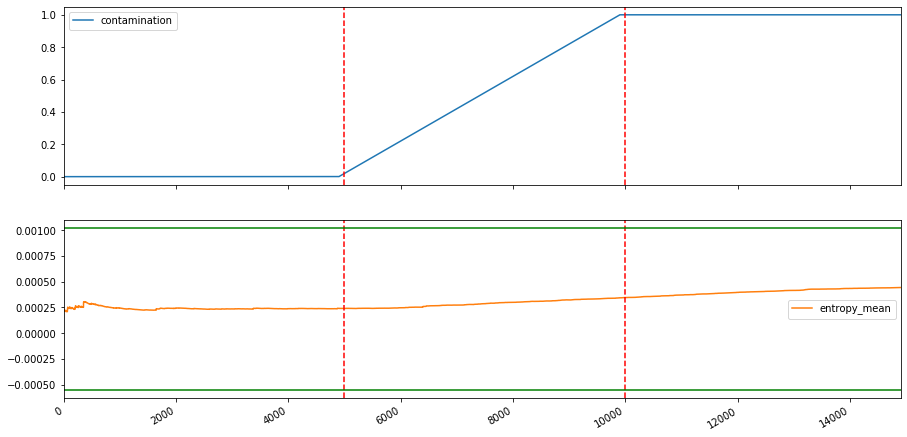

In [36]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

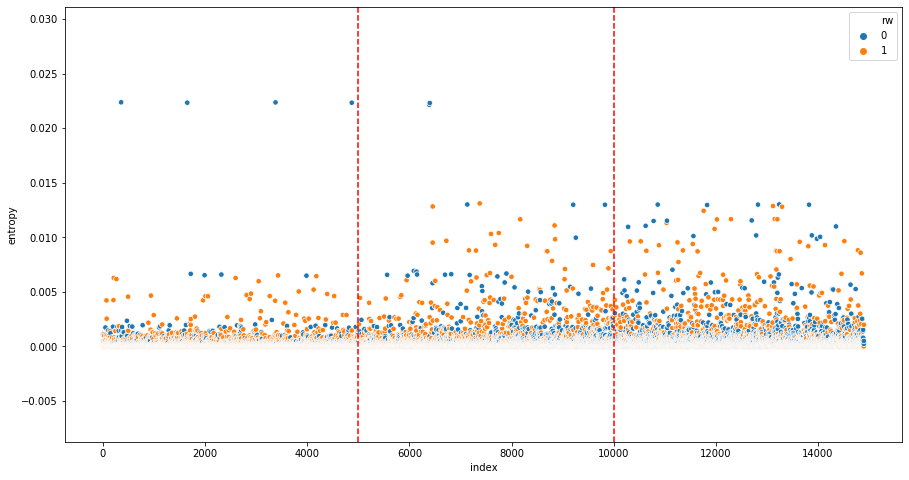

In [37]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="entropy", data=df.reset_index(), s=30, hue='rw')
ax.set(ylim=(-0.1, None))
plt.axvline(cd_start, c='r', linestyle='dashed')
plt.axvline(cd_full, c='r', linestyle='dashed')

### Sliding window

In [38]:
cd_start = 5000
nb_samples_tot = 15000
start = 0
window_size = 500

In [39]:
df, window_start, window_full = vsf.sliding_window(vae, X_test, y_test, X_red, y_red, window_size, cd_start, nb_samples_tot, start)

[0.00020602792]
[0.00020602792, 0.00021026169]
[0.00020602792, 0.00021026169, 0.00028287966]
[0.00020602792, 0.00021026169, 0.00028287966, 0.00020788731]
[0.00020602792, 0.00021026169, 0.00028287966, 0.00020788731, 0.00026404098]
[0.00020602792, 0.00021026169, 0.00028287966, 0.00020788731, 0.00026404098, 0.00024292966]
[0.00020602792, 0.00021026169, 0.00028287966, 0.00020788731, 0.00026404098, 0.00024292966, 0.00019191146]
[0.00020602792, 0.00021026169, 0.00028287966, 0.00020788731, 0.00026404098, 0.00024292966, 0.00019191146, 0.00022037461]
[0.00020602792, 0.00021026169, 0.00028287966, 0.00020788731, 0.00026404098, 0.00024292966, 0.00019191146, 0.00022037461, 0.00023713325]
[0.00020602792, 0.00021026169, 0.00028287966, 0.00020788731, 0.00026404098, 0.00024292966, 0.00019191146, 0.00022037461, 0.00023713325, 0.00028826372]
[0.00020602792, 0.00021026169, 0.00028287966, 0.00020788731, 0.00026404098, 0.00024292966, 0.00019191146, 0.00022037461, 0.00023713325, 0.00028826372, 0.00025092968]

In [40]:
df

,accuracy,contamination,entropy_mean,entropy_var
0,0.790000,0.00,0.000206,1.741202e-07
1,0.747495,0.00,0.000210,2.133350e-07
2,0.781563,0.00,0.000283,2.080578e-06
3,0.805611,0.00,0.000208,2.263192e-07
4,0.785571,0.00,0.000264,1.251280e-06
5,0.747495,0.00,0.000243,2.854697e-07
6,0.779559,0.00,0.000192,1.276596e-07
7,0.803607,0.00,0.000220,2.070603e-07
8,0.777555,0.00,0.000237,3.302042e-07
9,0.765531,0.00,0.000288,1.276656e-06


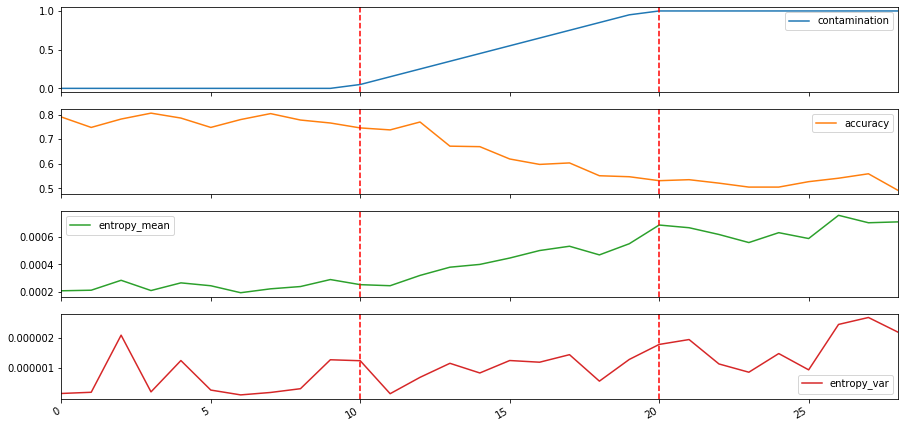

In [41]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(window_start, c='r', linestyle='dashed')
    ax.axvline(window_full, c='r', linestyle='dashed')

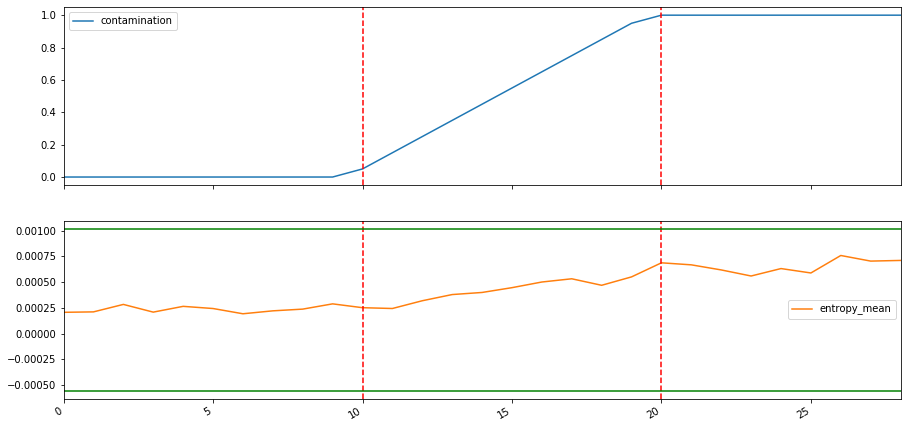

In [42]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(window_start, c='r', linestyle='dashed')
    ax.axvline(window_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

# ACDC

In [304]:
p = 1
pp = np.random.choice([0,1], p=[p, 1-p])

In [305]:
pp

0

In [129]:
z = np.random.rand(10) * np.random.randint(100, size=10)

In [130]:
z

array([ 2.45559931, 16.32795173,  3.39477637, 77.17835717,  7.96036917,
       12.13190417, 57.88428148, 22.77427401,  0.5942742 , 11.10560329])

In [131]:
for zz in z:
    mean = m.update(zz)
    var = v.update(zz)

In [132]:
print(np.mean(z))
print(np.std(z))

21.18073908966744
24.408838512067216


In [133]:
mean

Mean: 21.180739

In [134]:
np.sqrt(var.get())

25.729174912455914